In [1]:
import torch
from torch.optim import AdamW
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import trange, tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def one_hot_binary(label):
    a = [0, 0]
    a[label] = 1
    return torch.tensor(a).to(torch.float)
    # return a

def one_hot_multiclass(label):
    a = [0, 0, 0, 0]
    a[label] = 1
    return torch.tensor(a).to(torch.float)

In [3]:
class BinaryNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ELU(),
            nn.Linear(1024, 2)
            # nn.ReLU(),
            # nn.Linear(512, 64),
            # nn.ReLU(),
            # nn.Linear(64, 2)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
class ClassificationDataset(Dataset):
	def __init__(self, embeddings, labels):
		self.embeddings = embeddings
		self.labels = labels

	def __len__(self):
		return len(self.embeddings)

	def __getitem__(self, idx):
		embed = self.embeddings[idx]
		label = self.labels[idx]
		return {'embed': embed, 'label': label}

In [5]:
polyhope_binary_labels = {'Hope':1, 'Not Hope':0}
polyhope_inv_binary_labels = {v: k for k, v in polyhope_binary_labels.items()}

binary_polyhope = 'binary'
multi_polyhope = 'multiclass'

binary_classes = 2
multi_classes = 4

batch_size = 8
num_epochs = 50
learning_rate = 2e-5

polyhope_multi_labels = {'Not Hope':0, 'Generalized Hope':1, 'Realistic Hope':2, 'Unrealistic Hope':3}
polyhope_inv_multi_labels = {v: k for k, v in polyhope_multi_labels.items()}

train_file = "../data/train_polyhope_english.csv"
val_file = "../data/val_polyhope_english.csv"

df_train = pd.read_csv(train_file)
df_val = pd.read_csv(val_file)

# train_labels = df_train['binary']
# val_labels = df_val['binary']

train_labels = df_train['multiclass']
val_labels = df_val['multiclass']

# temp = [one_hot_binary(polyhope_binary_labels[label]) for label in train_labels]
# train_labels = torch.from_numpy(np.array(temp))
# temp = [one_hot_binary(polyhope_binary_labels[label]) for label in val_labels]
# val_labels = torch.from_numpy(np.array(temp))

temp = [one_hot_binary(polyhope_multi_labels[label]) for label in train_labels]
train_labels = torch.from_numpy(np.array(temp))
temp = [one_hot_binary(polyhope_multi_labels[label]) for label in val_labels]
val_labels = torch.from_numpy(np.array(temp))

train_embeds = torch.load('../data/embeds/polyhope_train_english_embeds_t5_large.pt')
val_embeds = torch.load('../data/embeds/polyhope_val_english_embeds_t5_large.pt')

train_dataset = ClassificationDataset(train_embeds, train_labels)
val_dataset = ClassificationDataset(val_embeds, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def train(model, data_loader, optimizer, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        embed = batch['embed'].to(device)
        labels = batch['label'].to(device)
        outputs = model(embed)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

In [7]:
def evaluate(model, data_loader, device):
    a = []
    for i in range(16):
        # a.append([0, 1])
        a.append([0, 1, 2, 3])
    cats = torch.tensor(a).to(device)
    b= []
    for i in range(8):
        # b.append([0, 1])
        b.append([0, 1, 2, 3])
    cats8 = torch.tensor(b).to(device)
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            embed = batch['embed'].to(device)
            labels = batch['label'].to(device)
            outputs = model(embed)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            if pred.shape[0] == 8:
                pred = torch.sum(cats8 * pred, dim=1)
                actual = torch.sum(cats8 * labels, dim=1)
            else:
                pred = torch.sum(cats * pred, dim=1)
                actual = torch.sum(cats * labels, dim=1)
            predictions.extend(pred.cpu().tolist())
            actual_labels.extend(actual.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), predictions

In [8]:
model = BinaryNetClassifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

In [9]:
acc = []
for epoch in trange(num_epochs):
    train(model, train_loader, optimizer, device)
    accuracy, report, predictions = evaluate(model, val_loader, device)
    acc.append(accuracy)
    # print(f"Validation Accuracy: {accuracy}")
    # print(f"Report: {report}")
accuracy, report, predictions = evaluate(model, val_loader, device)
print(f"Validation Accuracy: {accuracy}")
print(f"Report: {report}")

100%|███████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]

Validation Accuracy: 0.8013565891472868
Report:               precision    recall  f1-score   support

         0.0       0.80      0.79      0.79       502
         1.0       0.80      0.82      0.81       530

    accuracy                           0.80      1032
   macro avg       0.80      0.80      0.80      1032
weighted avg       0.80      0.80      0.80      1032



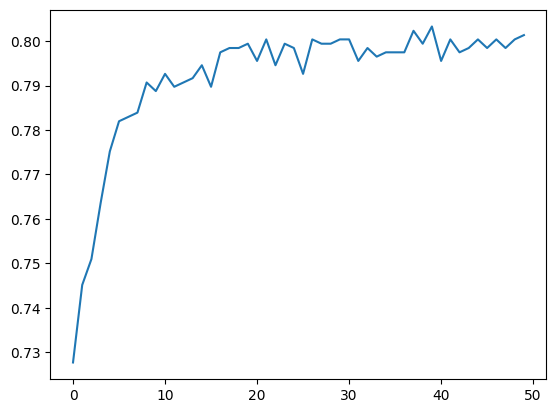

In [10]:
import matplotlib.pyplot as plt
x = [i for i in range(len(acc))]
plt.plot(x, acc)

In [11]:
# torch.save(model, '../models/polyhope_eng_bin_embed_nn.pt')